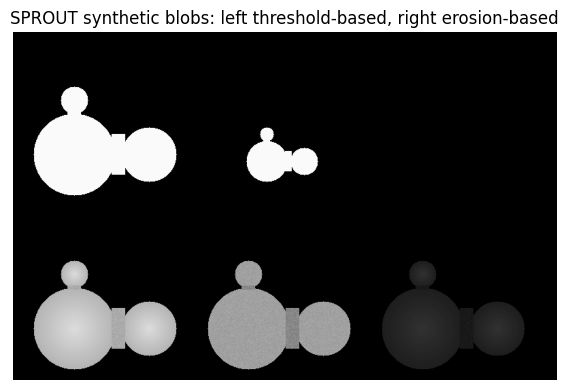

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile
np.random.seed(42)
def draw_blob(img, cfg):
    """
    cfg keys:
      - center: (y, x)
      - radius: float
      - mode: "constant" | "radial"
      - value: int (for constant)
      - value_center, value_edge: ints (for radial)
    """
    h, w = img.shape
    yy, xx = np.mgrid[0:h, 0:w]
    cy, cx = cfg["center"]
    r = cfg["radius"]
    mask = (yy - cy) ** 2 + (xx - cx) ** 2 <= r ** 2

    mode = cfg.get("mode", "constant")
    if mode == "constant":
        val = cfg.get("value", 160)
        img[mask] = val
    elif mode == "radial":
        v_center = cfg.get("value_center", 160)
        v_edge = cfg.get("value_edge", 180)
        dist = np.sqrt((yy - cy) ** 2 + (xx - cx) ** 2)
        # normalised 0 at centre, 1 at radius
        t = np.clip(dist / r, 0, 1)
        vals = v_center + (v_edge - v_center) * t
        img[mask] = vals[mask].astype(img.dtype)
    elif mode == "noise":
        vmin = cfg.get("value_min", 150)
        vmax = cfg.get("value_max", 200)
        noise = np.random.randint(vmin, vmax + 1,
                                  size=img.shape,
                                  dtype=img.dtype)
        img[mask] = noise[mask]

def draw_bridge(img, cfg):
    """
    Axis-aligned 'bridge' between two points.
    cfg keys:
      - p1: (y1, x1)
      - p2: (y2, x2)
      - halfwidth: int
      - mode: "constant" | "linear"
      - value: int (for constant)
      - value_start, value_end: ints (for linear gradient)
        gradient direction = along the long axis (x if horizontal, y if vertical)
    """
    h, w = img.shape
    yy, xx = np.mgrid[0:h, 0:w]
    y1, x1 = cfg["p1"]
    y2, x2 = cfg["p2"]
    hw = cfg.get("halfwidth", 3)
    mode = cfg.get("mode", "constant")

    if y1 == y2:  # horizontal bridge
        y0 = y1
        xa, xb = sorted([x1, x2])
        region = (slice(y0 - hw, y0 + hw), slice(xa, xb))
        if mode == "constant":
            val = cfg.get("value", 120)
            img[region] = val
        elif mode == "linear":
            v_start = cfg.get("value_start", 100)
            v_end = cfg.get("value_end", 140)
            length = xb - xa
            if length <= 0:
                return
            x_coords = np.arange(xa, xb)
            t = (x_coords - xa) / max(length - 1, 1)
            vals = v_start + (v_end - v_start) * t  # shape (length,)
            # broadcast to rows in region
            block = np.tile(vals, (2*hw, 1))
            img[region] = block.astype(img.dtype)

        elif mode == "radial":
            v_center = cfg.get("value_center", 130)
            v_edge = cfg.get("value_edge", 90)
            ys = np.arange(-hw, hw)               # vertical offsets
            t = np.abs(ys) / max(hw - 1, 1)       # 0 at center, 1 at edge
            row_vals = v_center + (v_edge - v_center) * t  # shape (2*hw,)
            length = xb - xa
            block = np.tile(row_vals[:, None], (1, length))
            img[region] = block.astype(img.dtype)
        elif mode == "noise":
            vmin = cfg.get("value_min", 100)
            vmax = cfg.get("value_max", 150)
            region_shape = (2 * hw, xb - xa)
            noise = np.random.randint(vmin, vmax + 1,
                                      size=region_shape,
                                      dtype=img.dtype)
            img[region] = noise

    elif x1 == x2:  # vertical bridge
        x0 = x1
        ya, yb = sorted([y1, y2])
        region = (slice(ya, yb), slice(x0 - hw, x0 + hw))
        if mode == "constant":
            val = cfg.get("value", 120)
            img[region] = val
        elif mode == "linear":
            v_start = cfg.get("value_start", 100)
            v_end = cfg.get("value_end", 140)
            length = yb - ya
            if length <= 0:
                return
            y_coords = np.arange(ya, yb)
            t = (y_coords - ya) / max(length - 1, 1)
            vals = v_start + (v_end - v_start) * t  # shape (length,)
            block = np.tile(vals[:, None], (1, 2*hw))
            img[region] = block.astype(img.dtype)
        elif mode == "radial":
            v_center = cfg.get("value_center", 130)
            v_edge = cfg.get("value_edge", 90)
            xs = np.arange(-hw, hw)
            t = np.abs(xs) / max(hw - 1, 1)
            col_vals = v_center + (v_edge - v_center) * t  # shape (2*hw,)
            length = yb - ya
            block = np.tile(col_vals, (length, 1))
            img[region] = block.astype(img.dtype)
        elif mode == "noise":
            vmin = cfg.get("value_min", 100)
            vmax = cfg.get("value_max", 150)
            region_shape = (yb - ya, 2 * hw)
            noise = np.random.randint(vmin, vmax + 1,
                                      size=region_shape,
                                      dtype=img.dtype)
            img[region] = noise

        
    else:
        # For now only support axis-aligned; could be extended to general line
        raise ValueError("Only horizontal or vertical bridges are supported.")


def generate_from_config(shape, blobs, bridges, bg_value=0, dtype=np.uint8):
    img = np.full(shape, bg_value, dtype=dtype)
    for b in blobs:
        draw_blob(img, b)
    for br in bridges:
        draw_bridge(img, br)
    return img


# --- Example configuration: left threshold-based, right erosion-based in one image ---
H = 512
W = 800
X_offset = 256
Y_offset = 256

ero_size_scale = 2  # adjust size ratio if needed

after_scale_X_offset = 200
after_scale_Y_offset = 100

blobs_cfg = [
    # Up Left side blobs (erosion demo)
    {"center": (100, 90), "radius": 20, "mode": "constant", "value": 250},
    {"center": (180, 90), "radius": 60, "mode": "constant", "value": 250},
    {"center": (180, 200), "radius": 40, "mode": "constant", "value": 250},
    
    {"center": (100//ero_size_scale + after_scale_Y_offset, 
                (90+X_offset)//ero_size_scale + after_scale_X_offset),
     "radius": 20//ero_size_scale, 
     "mode": "constant", 
     "value": 250},
    {"center": (180//ero_size_scale + after_scale_Y_offset, 
                (90+X_offset)//ero_size_scale + after_scale_X_offset), 
     "radius": 60//ero_size_scale,
    "mode": "constant", 
    "value": 250},
    {"center": (180//ero_size_scale + after_scale_Y_offset  , 
                (200+X_offset)//ero_size_scale + after_scale_X_offset),
     "radius": 40//ero_size_scale,
     "mode": "constant",
     "value": 250},
    
    # Down Left side blobs (threshold demo) – note x + 256 shift
    {"center": (100+Y_offset, 90), "radius": 20, "mode": "radial",     "value_center": 220, "value_edge": 180},
    {"center": (180+Y_offset, 90), "radius": 60, "mode": "radial", "value_center": 220, "value_edge": 180},
    {"center": (180+Y_offset, 200), "radius": 40, "mode": "radial", "value_center": 220, "value_edge": 180},
    
    # down middle blobs (erosion demo with different intensities)
    {"center": (100+Y_offset , (90+X_offset)), "radius": 20, "mode": "noise", "value_min": 150, "value_max": 170},
    {"center": (180+Y_offset, (90+X_offset)), "radius": 60, "mode": "noise", "value_min": 150, "value_max": 170},
    {"center": (180+Y_offset, (200+X_offset)), "radius": 40, "mode": "noise", "value_min": 150, "value_max": 170},
    
    # Down Right, threshold demo with different intensities
    {"center": (100+Y_offset , 90+X_offset*2), "radius": 20, "mode": "radial", "value_center": 50, "value_edge": 30},
    {"center": (180+Y_offset, 90+X_offset*2), "radius": 60, "mode": "radial", "value_center": 50, "value_edge": 30},
    {"center": (180+Y_offset, 200+X_offset*2), "radius": 40, "mode": "radial", "value_center": 50, "value_edge": 30},
]

bridges_cfg = [
    # Left: lower intensity bridges (erosion separable)
    {
        "p1": (120, 90+10), "p2": (120, 90-10),
        "halfwidth": 3,
        "mode": "constant",
        "value": 250,  # e.g. 210
    },
    {
        "p1": (180+30, 155), "p2": (180-30, 155),
        "halfwidth": 10,
        "mode": "constant",
        "value": 250,  # e.g. 210
    },
    # Right: same-intensity or slight gradient bridges (erosion separable)
    {
        "p1": (120//ero_size_scale + after_scale_Y_offset, 
               (90+X_offset+10)//ero_size_scale + after_scale_X_offset), 
        "p2": (120//ero_size_scale + after_scale_Y_offset, 
               (90+X_offset-10)//ero_size_scale + after_scale_X_offset),
        "halfwidth": 2,
        "mode": "constant",
        "value": 250,  # e.g. 210
    },
    {
        "p1": ((180+30)//ero_size_scale + after_scale_Y_offset, 
               (155+X_offset)//ero_size_scale + after_scale_X_offset),
        "p2": ((180-30)//ero_size_scale + after_scale_Y_offset, 
               (155+X_offset)//ero_size_scale + after_scale_X_offset),
        "halfwidth": 10//ero_size_scale,
        "mode": "constant",
        "value": 250,  # e.g. 210
    },
    
    
    # Down left
    
    {   
        "p1": (120+Y_offset, 90+10), "p2": (120+Y_offset, 90-10),
        "halfwidth": 3,
        "mode": "noise",
        "value_min": 160,
        "value_max": 180,  # slight gradient along bridge
    },
    
    {   
        "p1": (180+30+Y_offset, 155), "p2": (180-30+Y_offset, 155),
        "halfwidth": 10,
        "mode": "noise",
        "value_min": 160,
        "value_max": 180,  # slight gradient along bridge
    },
    
    
    # Down middle
    {   
        "p1": (120+Y_offset, 90+X_offset+10), "p2": (120+Y_offset, 90+X_offset-10),
        "halfwidth": 3,
        "mode": "noise",
        "value_min": 120,
        "value_max": 150
    },
    {
        "p1": (180+30+Y_offset, 155+X_offset), "p2": (180-30+Y_offset, 155+X_offset),
        "halfwidth": 10,
        "mode": "noise",
        "value_min": 120,
        "value_max": 150,  # slight gradient along bridge
    },
    
    # Down Right: lower intensity bridges (threshold separable)
    {
        "p1": (120+Y_offset, 90+X_offset*2+10), "p2": (120+Y_offset, 90+X_offset*2-10),
        "halfwidth": 3,
        "mode": "noise",
         "value_min": 20,
         "value_max": 30
    },
    {
        "p1": (180+30+Y_offset, 155+X_offset*2), "p2": (180-30+Y_offset, 155+X_offset*2),
        "halfwidth": 10,
        "mode": "noise",
        "value_min": 20,
        "value_max": 30,  # slight gradient along bridge
    },
    
]

img_demo = generate_from_config((H, W), blobs_cfg, bridges_cfg, bg_value=0)

# Preview with matplotlib for inspection
plt.figure(figsize=(8, 4))
plt.imshow(img_demo, cmap="gray", vmin=0, vmax=255)
plt.title("SPROUT synthetic blobs: left threshold-based, right erosion-based")
plt.axis("off")
plt.tight_layout()
plt.show()

# # Save to file after inspection
    
out_path_tif = "../demo_data/simple_demo.tif"
tifffile.imwrite(out_path_tif, img_demo.astype(np.uint8))
